<a href="https://colab.research.google.com/github/arora-akshat25/Fake-social-media-account-detection/blob/main/socialmedia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)

import seaborn as sns
import matplotlib.pyplot as plt

from joblib import dump, load


In [2]:
# Load CSV
df = pd.read_csv("bots_vs_users.csv")

print(df.head())
print(df.tail())
print(df.info())


  has_domain has_birth_date has_photo can_post_on_wall can_send_message  \
0        1.0            1.0       0.0              0.0              0.0   
1        1.0            1.0       0.0              0.0              0.0   
2        1.0            1.0       0.0              0.0              0.0   
3        1.0            1.0       0.0              0.0              0.0   
4        1.0            1.0       0.0              0.0              0.0   

  has_website gender has_short_name has_first_name has_last_name  ...  \
0         0.0    1.0            1.0            1.0           1.0  ...   
1         0.0    1.0            1.0            1.0           1.0  ...   
2         0.0    1.0            1.0            1.0           1.0  ...   
3         0.0    1.0            1.0            1.0           1.0  ...   
4         0.0    1.0            1.0            1.0           1.0  ...   

  ads_ratio avg_views  posting_frequency_days phone_numbers_ratio  \
0       NaN       NaN                    

In [3]:
df.describe()

,target,posts_count,avg_likes,links_ratio,hashtags_ratio,avg_keywords,avg_text_length,attachments_ratio,avg_comments,reposts_ratio,ads_ratio,avg_views,posting_frequency_days,phone_numbers_ratio,avg_text_uniqueness
count,5874.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000
mean,0.500000,18.629044,19.552487,0.156463,0.143918,7.730661,544.752035,0.895945,0.610812,0.433638,0.002667,623.834788,66.330065,0.000568,0.668009
std,0.500043,4.231994,41.954881,0.202730,0.187085,11.278711,746.728130,0.170084,2.461709,0.397830,0.033136,1617.635460,154.970296,0.009545,0.229815
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,0.400000,0.000000,0.000000,1.100000,86.600000,0.850000,0.000000,0.050000,0.000000,9.125000,1.980000,0.000000,0.580000
50%,0.500000,20.000000,7.600000,0.100000,0.050000,3.400000,267.800000,0.950000,0.000000,0.300000,0.000000,268.950000,30.950000,0.000000,0.710000
75%,1.000000,20.000000,26.075000,0.200000,0.200000,7.850000,616.850000,1.000000,0.200000,0.900000,0.000000,746.050000,89.480000,0.000000,0.830000
max,1.000000,20.000000,894.900000,1.000000,1.000000,61.600000,5841.250000,1.000000,64.050000,1.000000,0.950000,41415.700000,2866.590000,0.300000,1.000000


In [4]:
activity_cols = [
    'posts_count', 'avg_likes', 'links_ratio', 'hashtags_ratio', 'avg_keywords',
    'avg_text_length', 'attachments_ratio', 'avg_comments', 'reposts_ratio',
    'ads_ratio', 'avg_views', 'posting_frequency_days', 'phone_numbers_ratio',
    'avg_text_uniqueness'
]

target_col = 'target'


In [5]:
def preprocess_features(df_raw: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    df = df_raw.copy()

    # 1) Drop city if present (100% NaN in your dataset)
    if 'city' in df.columns:
        df = df.drop(columns=['city'])

    # 2) Separate target
    y = df[target_col]
    X = df.drop(columns=[target_col])

    # 3) Handle activity columns: NaN -> 0
    for col in activity_cols:
        if col in X.columns:
            X[col] = pd.to_numeric(X[col], errors='coerce')
            X[col] = X[col].fillna(0)

    # 4) Handle object columns: map yes/no/true/false etc.
    obj_cols = X.select_dtypes(include=['object']).columns.tolist()

    true_values = ["yes", "true", "y", "1", "t", "present"]
    false_values = ["no", "false", "n", "0", "f", "none"]

    for col in obj_cols:
        X[col] = X[col].astype(str).str.lower().str.strip()

        # treat these as missing
        X[col].replace(
            ["unknown", "?", "n/a", "na", "null", "none", ""],
            np.nan,
            inplace=True
        )

        X[col].replace(true_values, 1, inplace=True)
        X[col].replace(false_values, 0, inplace=True)

    # 5) Convert EVERYTHING to numeric, remaining weird stuff -> NaN
    X = X.apply(pd.to_numeric, errors='coerce')

    # 6) Fill any leftover NaNs with column mean
    X = X.fillna(X.mean(numeric_only=True))

    print("Remaining NaNs in X:", X.isna().sum().sum())

    return X, y


In [6]:
X, y = preprocess_features(df)


/tmp/ipython-input-1874854807.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].replace(
/tmp/ipython-input-1874854807.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, in

Remaining NaNs in X: 0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5874 entries, 0 to 5873
Data columns (total 60 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   has_domain                  5874 non-null   object 
 1   has_birth_date              5874 non-null   object 
 2   has_photo                   5874 non-null   object 
 3   can_post_on_wall            5874 non-null   object 
 4   can_send_message            5874 non-null   object 
 5   has_website                 5874 non-null   object 
 6   gender                      5874 non-null   object 
 7   has_short_name              5874 non-null   object 
 8   has_first_name              5874 non-null   object 
 9   has_last_name               5874 non-null   object 
 10  access_to_closed_profile    5874 non-null   object 
 11  is_profile_closed           5874 non-null   object 
 12  target                      5874 non-null   int64  
 13  has_nickname                5874 

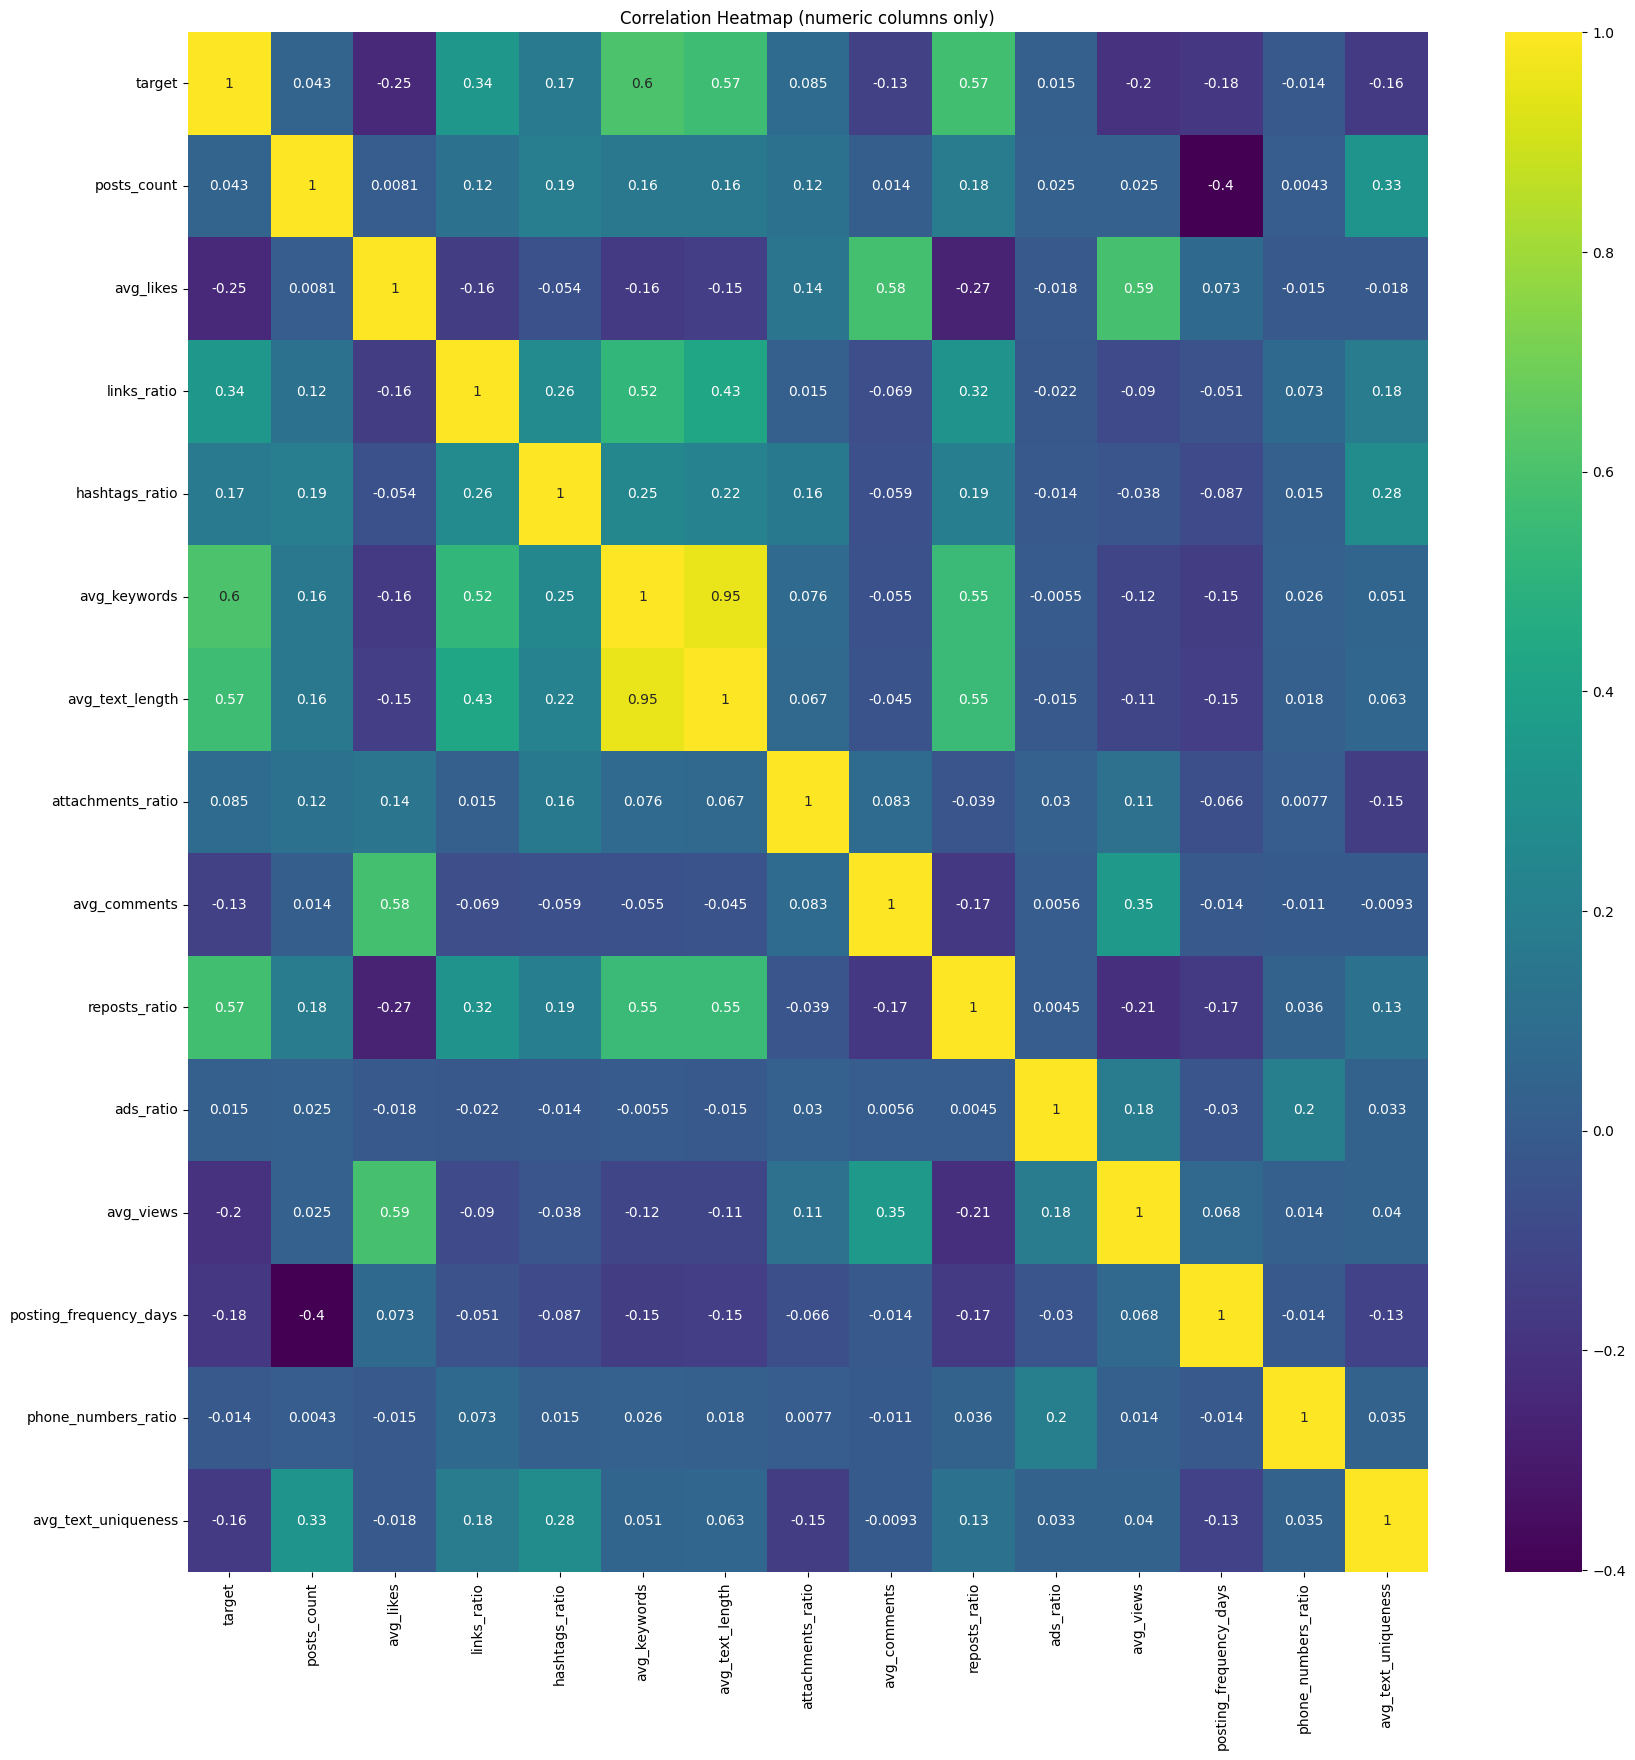

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title("Correlation Heatmap (numeric columns only)")
plt.show()


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


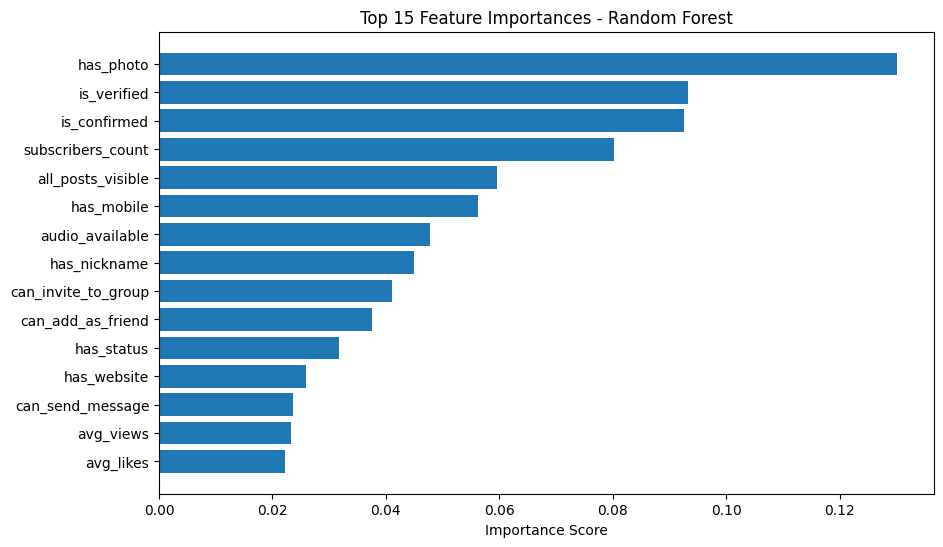

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y)
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importances['feature'][:15], importances['importance'][:15])
plt.gca().invert_yaxis()
plt.title('Top 15 Feature Importances - Random Forest')
plt.xlabel('Importance Score')
plt.show()


In [11]:
sample = X_test.iloc[0:5]    # take first 5 accounts
sample_pred = rf.predict(sample)
sample_prob = rf.predict_proba(sample)[:, 1]

sample_result = sample.copy()
sample_result['predicted'] = sample_pred
sample_result['real_probability'] = sample_prob
print(sample_result)


      has_domain  has_birth_date  has_photo  can_post_on_wall  \
1585         1.0             1.0        0.0               0.0   
4134         1.0             1.0        1.0               0.0   
2172         1.0             1.0        0.0               0.0   
729          1.0             1.0        0.0               0.0   
3027         1.0             1.0        1.0               0.0   

      can_send_message  has_website  gender  has_short_name  has_first_name  \
1585               1.0          0.0     2.0             1.0             1.0   
4134               1.0          0.0     1.0             1.0             1.0   
2172               0.0          0.0     1.0             1.0             1.0   
729                0.0          0.0     1.0             1.0             1.0   
3027               1.0          0.0     1.0             1.0             1.0   

      has_last_name  ...  avg_views  posting_frequency_days  \
1585            1.0  ...        0.0                    0.00   
4134    

In [12]:
fake_score = 1 - rf.predict_proba(X)[:, 1]
df['fake_probability'] = fake_score
print(fake_score)

[0.0118579  0.0118579  0.0118579  ... 0.63818613 1.         1.        ]


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [21]:
log_reg = LogisticRegression(max_iter=80000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
train_accuracylog = log_reg.score(X_train, y_train)
print(f"Logistic Regression Train Accuracy: {train_accuracylog * 100:.2f}%")
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log) * 100)
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

Logistic Regression Train Accuracy: 95.77%
Logistic Regression Accuracy: 94.8936170212766
[[555  33]
 [ 27 560]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       588
           1       0.94      0.95      0.95       587

    accuracy                           0.95      1175
   macro avg       0.95      0.95      0.95      1175
weighted avg       0.95      0.95      0.95      1175



Decision Tree Train Accuracy: 98.49%
Decision Tree Accuracy: 96.51063829787235
[[569  19]
 [ 22 565]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       588
           1       0.97      0.96      0.96       587

    accuracy                           0.97      1175
   macro avg       0.97      0.97      0.97      1175
weighted avg       0.97      0.97      0.97      1175



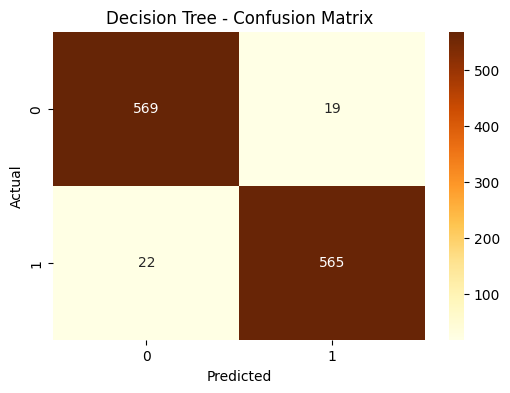

In [20]:
dt = DecisionTreeClassifier(max_depth=12, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
train_accdt = dt.score(X_train, y_train)
print(f"Decision Tree Train Accuracy: {train_accdt * 100:.2f}%")
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt) * 100)
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='YlOrBr')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree - Confusion Matrix')
plt.show()


Random Forest Train Accuracy: 98.62%
Random Forest Accuracy: 96.68085106382979

Random Forest Confusion Matrix:
 [[572  16]
 [ 23 564]]

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       588
           1       0.97      0.96      0.97       587

    accuracy                           0.97      1175
   macro avg       0.97      0.97      0.97      1175
weighted avg       0.97      0.97      0.97      1175



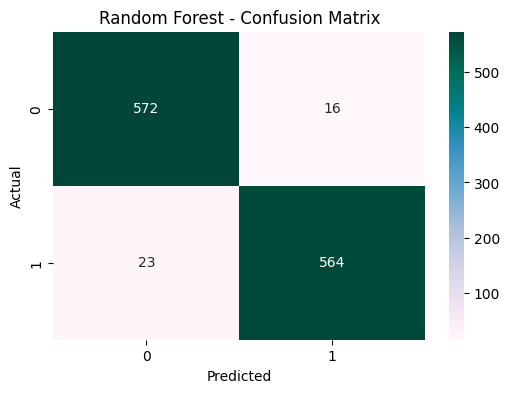

In [19]:
rf = RandomForestClassifier(
    n_estimators=350,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
train_accuracy = rf.score(X_train, y_train)
print(f"Random Forest Train Accuracy: {train_accuracy * 100:.2f}%")
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf) * 100)
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("\nRandom Forest Confusion Matrix:\n", cm_rf)
print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='PuBuGn')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest - Confusion Matrix')
plt.show()


XGBoost Train Accuracy: 98.51%
XGBoost Accuracy : 97.191%
Confusion Matrix:
 [[573  15]
 [ 18 569]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       588
           1       0.97      0.97      0.97       587

    accuracy                           0.97      1175
   macro avg       0.97      0.97      0.97      1175
weighted avg       0.97      0.97      0.97      1175



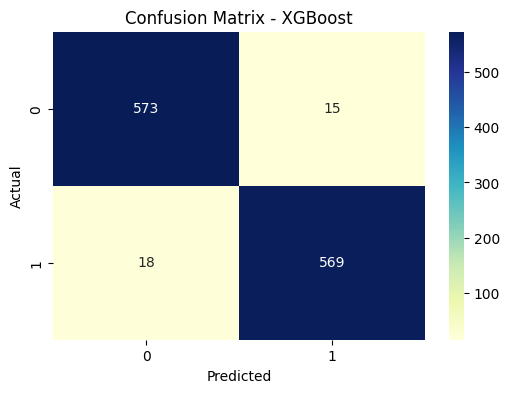

In [25]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# 1) Create the model (tune hyperparams later if desired)
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.08,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# 2) Fit the model
xgb.fit(X_train, y_train)

# 3) Predict
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

# 4) Metrics
accxgtrain = xgb.score(X_train, y_train)
print(f"XGBoost Train Accuracy: {accxgtrain * 100:.2f}%")
acc  = accuracy_score(y_test, y_pred_xgb)

print(f"XGBoost Accuracy : {acc*100:.3f}%")

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

# 5) Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()

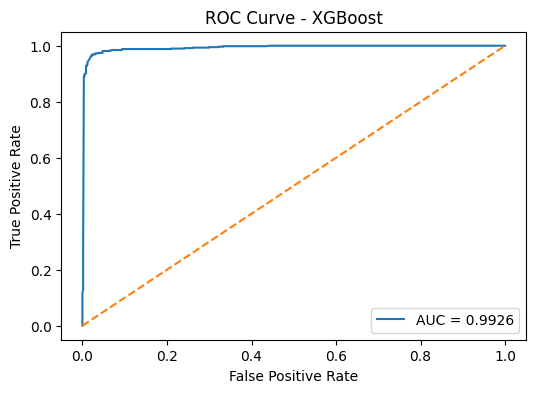

In [27]:
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

# Compute ROC curve values
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr_xgb, tpr_xgb, label='AUC = %0.4f' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend()
plt.show()

In [26]:
print("FINAL MODEL SUMMARY")
print("---------------------")
print("Model: XGBoost")
print("Train/Test Split: 80/20")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb) * 100)
print("AUC:", roc_auc * 100)

FINAL MODEL SUMMARY
---------------------
Model: XGBoost
Train/Test Split: 80/20
Accuracy: 97.19148936170214
AUC: 99.26091390559631


The XGBoost gives the best accuracy with a 97.171%